In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import os

In [2]:
data = pd.read_csv("data_nonconcat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.asarray(y_train.values.tolist())
y_test = np.asarray(y_test.values.tolist())

In [3]:
def modelAccuracy(modelname, predictions, test_gs):
    mcounter = 0
    for i in range(len(predictions)):
        if(predictions[i]!=test_gs[i]):
            mcounter+=1
    print(str(modelname)+" accuracy: "+str((1-(mcounter/len(predictions)))))
    return (1-(mcounter/len(predictions)))


In [4]:
def displayStats(predictions, truth):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    cmat = confusion_matrix(truth,predictions)
    disp = ConfusionMatrixDisplay(cmat)
    disp.plot()
    plt.show()

# Basic Catboost Classifier to establish a baseline

---

In [5]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train,y_train)

Learning rate set to 0.022413
0:	learn: 0.6893514	total: 64.6ms	remaining: 1m 4s
1:	learn: 0.6857156	total: 75.1ms	remaining: 37.5s
2:	learn: 0.6817358	total: 85.7ms	remaining: 28.5s
3:	learn: 0.6783232	total: 97.7ms	remaining: 24.3s
4:	learn: 0.6751536	total: 109ms	remaining: 21.6s
5:	learn: 0.6718597	total: 119ms	remaining: 19.8s
6:	learn: 0.6682032	total: 132ms	remaining: 18.7s
7:	learn: 0.6644885	total: 143ms	remaining: 17.8s
8:	learn: 0.6603522	total: 154ms	remaining: 16.9s
9:	learn: 0.6575370	total: 166ms	remaining: 16.4s
10:	learn: 0.6545324	total: 180ms	remaining: 16.2s
11:	learn: 0.6515957	total: 192ms	remaining: 15.8s
12:	learn: 0.6482439	total: 203ms	remaining: 15.4s
13:	learn: 0.6450161	total: 218ms	remaining: 15.3s
14:	learn: 0.6424572	total: 229ms	remaining: 15.1s
15:	learn: 0.6400338	total: 240ms	remaining: 14.8s
16:	learn: 0.6368506	total: 251ms	remaining: 14.5s
17:	learn: 0.6345235	total: 261ms	remaining: 14.2s
18:	learn: 0.6321616	total: 270ms	remaining: 13.9s
19:	lea

In [6]:
pred_test = cbm.predict(X_test)
modelAccuracy("CatBoost", pred_test, y_test)
soft_preds = cbm.predict_proba(X_test)[:,1]
print("CatBoost ROC-AUC: "+ str(roc_auc_score(y_test,soft_preds)))

CatBoost accuracy: 0.891156462585034
CatBoost ROC-AUC: 0.9611772362443312


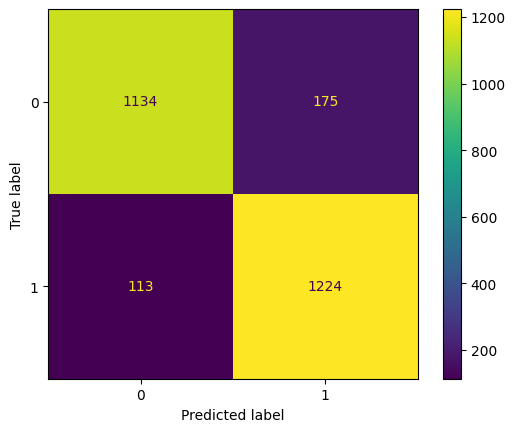

In [7]:
displayStats(pred_test,y_test)

# Sanity Checking
---
Catboost accuracy is better than expected, so we want to ensure that the dataset is not messed up in any way. As such, we're going to train catboost on completely random data of the same shape, and make sure that it does worse than our actual dataset.

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6174, 34)
(2646, 34)
(6174,)
(2646,)


In [9]:
rand_X_train = np.random.rand(102,2040)
rand_X_train.shape

(102, 2040)

In [10]:
cbm2 = CatBoostClassifier()
cbm2.fit(rand_X_train,y_train)

CatBoostError: Length of label=6174 and length of data=102 is different.

In [ ]:
pred_test2 = cbm2.predict(X_test)
modelAccuracy("CatBoost RANDOM", pred_test2, y_test)
soft_preds2 = cbm2.predict_proba(X_test)[:,1]
print("CatBoost RANDOM ROC-AUC: "+ str(roc_auc_score(y_test,soft_preds2)))

CatBoost RANDOM accuracy: 0.48888888888888893
CatBoost RANDOM ROC-AUC: 0.5138339920948616


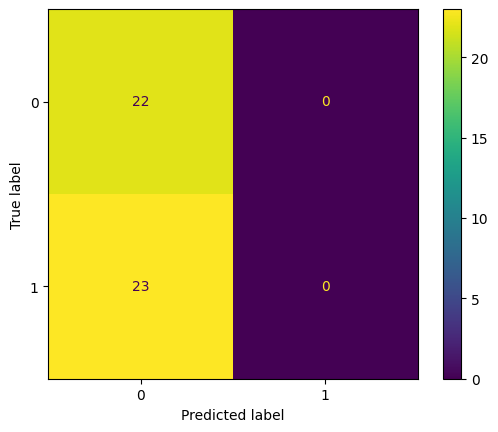

In [ ]:
displayStats(pred_test2,y_test)

## Sanity check conclusions
---
We can see that with completely random data the catboost classifier hovers around 50%. As such, we know our data is actually doing something, because without it, we are effectively predicting on random chance. 